In [152]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter(action='ignore')

In [5]:
%matplotlib inline
plt.style.use('seaborn-notebook')
plt.rcParams["figure.figsize"] = (20, 6) 
sns.set(context="paper", font="monospace") 

In [6]:
df = pd.read_csv('throughput_metrics.csv', parse_dates=['Time'], index_col='Time')
# df.reset_index(inplace=True)
df.head() 

,SiteA,SiteB,SiteC,SiteD,SiteE,SiteF
Time,,,,,,
2018-01-01 08:00:00,1.411093e+10,1.109243e+09,8.289831e+07,56650005.21,1.117868e+07,827420.9772
2018-01-01 09:00:00,1.345362e+10,1.242256e+09,4.375739e+04,49307351.26,7.070847e+06,913017.6007
2018-01-01 10:00:00,1.216888e+10,2.006322e+09,4.315725e+04,56843652.59,5.132826e+07,874471.3644
2018-01-01 11:00:00,1.123120e+10,1.073181e+09,8.277154e+07,46645240.59,5.217827e+06,837246.7783
2018-01-01 12:00:00,1.078085e+10,8.645069e+08,3.343548e+04,30966947.37,7.495363e+06,827143.7497


In [7]:
df.shape 

(8760, 6)

In [8]:
df.index

DatetimeIndex(['2018-01-01 08:00:00', '2018-01-01 09:00:00',
               '2018-01-01 10:00:00', '2018-01-01 11:00:00',
               '2018-01-01 12:00:00', '2018-01-01 13:00:00',
               '2018-01-01 14:00:00', '2018-01-01 15:00:00',
               '2018-01-01 16:00:00', '2018-01-01 17:00:00',
               ...
               '2018-12-31 22:00:00', '2018-12-31 23:00:00',
               '2019-01-01 00:00:00', '2019-01-01 01:00:00',
               '2019-01-01 02:00:00', '2019-01-01 03:00:00',
               '2019-01-01 04:00:00', '2019-01-01 05:00:00',
               '2019-01-01 06:00:00', '2019-01-01 07:00:00'],
              dtype='datetime64[ns]', name='Time', length=8760, freq=None)

In [9]:
sum(df.isna().sum())

0

In [ ]:
# fig.add_trace(go.Scatter(x=df.index, y=df['SiteA']),
#               row=1, col=1)

# fig.add_trace(go.Scatter(x=df.index, y=df['SiteB']),
#               row=1, col=1)

# fig.add_trace(go.Scatter(x=df.index, y=df['SiteC']),
#               row=2, col=1)

# fig.add_trace(go.Scatter(x=df.index, y=df['SiteD']),
#               row=2, col=2)

# fig.add_trace(go.Scatter(x=df.index, y=df['SiteE']),
#               row=3, col=1)

# fig.add_trace(go.Scatter(x=df.index, y=df['SiteF']),
#               row=3, col=2)

In [213]:
fig = go.Figure(go.Scatter(x=df.index, y=df['SiteA']))
fig.show()

In [217]:

fig = make_subplots(rows=6, cols=1, subplot_titles=df.columns,
                    vertical_spacing=0.05)

for i, col in enumerate(df.columns):
    fig.add_trace(go.Scatter(x=df.index, y=df[col],  
                             marker = dict(size = 10, 
                                           color = 'blue'),
                            textfont=dict(
                                color='black',
                                size=18,  
                                family='Times New Roman')),
                row=i+1, col=1)
    
fig.update_xaxes(
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.update_layout(showlegend=False, autosize=False,
    width=1300,
    height=1500,
    )
fig.show()



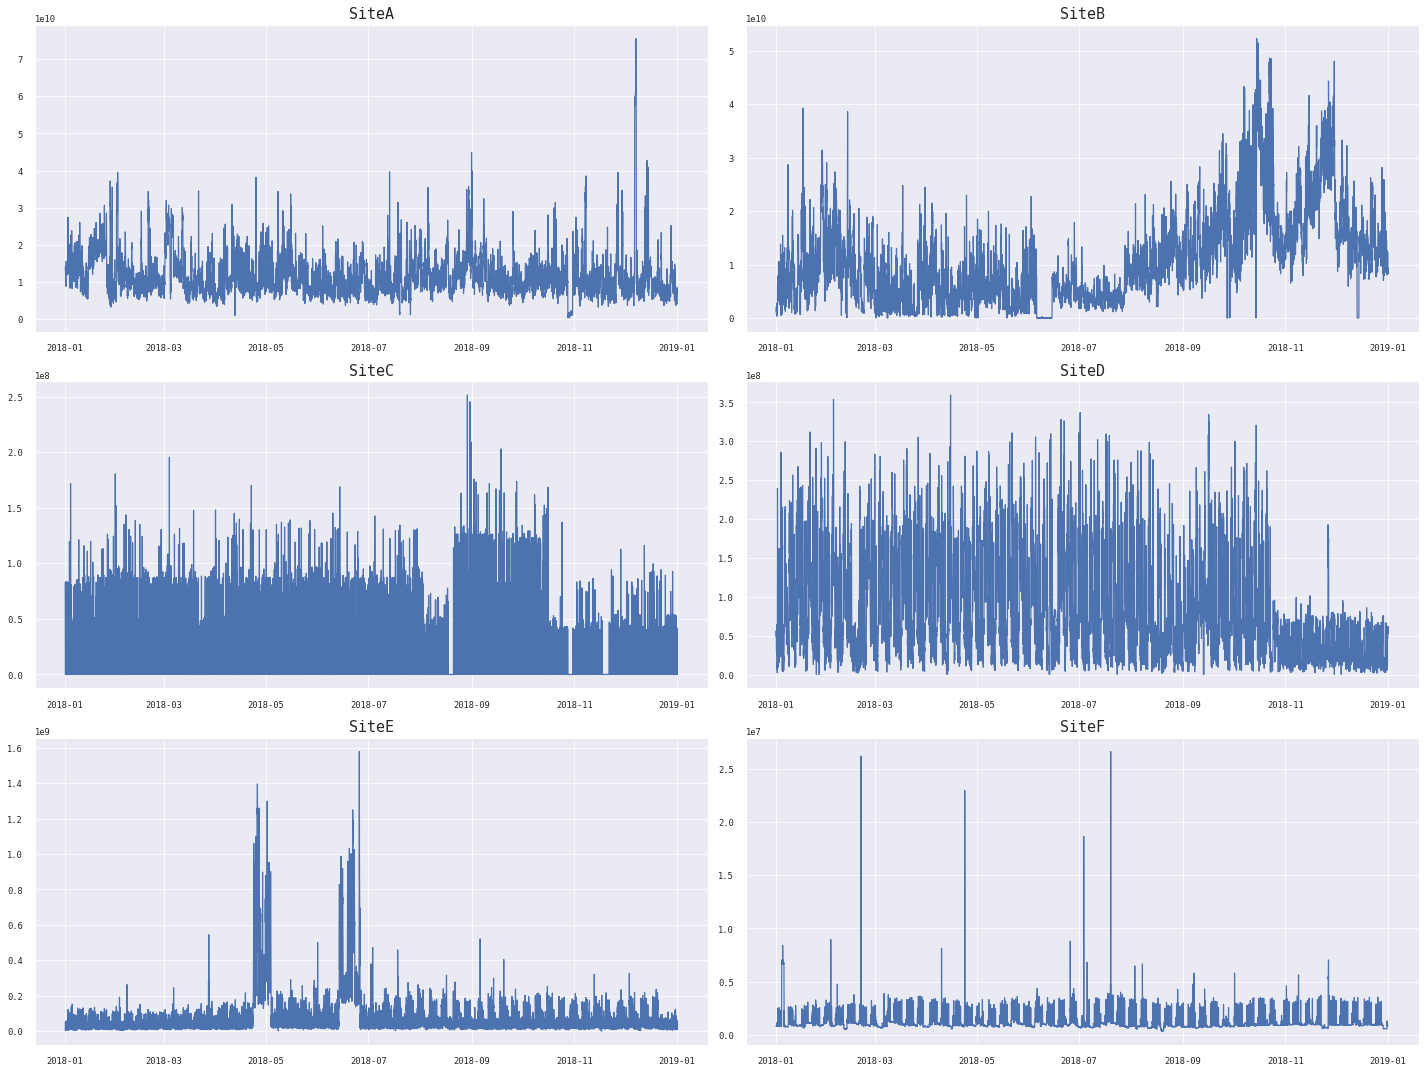

In [10]:
c = 1
fig = plt.figure(figsize=(20,15))
for col in df.columns:
    plt.subplot(3, 2, c)
    plt.title(f'{col}', size=15)
    plt.tight_layout()
    plt.plot(df[col])
    c += 1
plt.show() 

In [11]:
# missing value treatment
df['SiteB'][df['SiteB'] == 0] = df['SiteB'].mean()

In [12]:
df[df['SiteB'] == 0]

,SiteA,SiteB,SiteC,SiteD,SiteE,SiteF
Time,,,,,,


In [13]:
# checking stationarity 
cj_stat = coint_johansen(df,-1,1).eig 
print(cj_stat) 

[0.38782114 0.16822476 0.07955193 0.04133012 0.02690916 0.00513086]


In [15]:
nobs = 1
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)

(8759, 6)
(1, 6)


In [16]:
# fit the model
model = VAR(df_train)
model_fit = model.fit()

In [17]:
# Input data for forecasting
forecast_input = df_train.values[-nobs:]
forecast_input 

array([[6.88469466e+09, 9.62731719e+09, 7.31901028e+04, 6.26614479e+07,
        6.15230605e+07, 8.79444753e+05]])

In [18]:
# Forecast
fc = model_fit.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns)
df_forecast  

,SiteA,SiteB,SiteC,SiteD,SiteE,SiteF
Time,,,,,,
2019-01-01 07:00:00,7.546767e+09,9.795331e+09,2.600965e+07,6.448225e+07,6.392096e+07,1.032568e+06


In [19]:
result = dict()
# check rmse
for i in df.columns: 
    result[f'{i} RMSE'] = np.sqrt(mean_squared_error(df_forecast[i], df_test[i]))
    # print('rmse value for', i, 'is : ', np.sqrt(mean_squared_error(df_forecast[i], df_test[i])))
print(result) 

{'SiteA RMSE': 1128807727.8593187, 'SiteB RMSE': 2484787615.5402966, 'SiteC RMSE': 25936459.75449342, 'SiteD RMSE': 8183503.121821545, 'SiteE RMSE': 52947582.644412406, 'SiteF RMSE': 124809.94446083612}


In [38]:
# make final predictions
model = VAR(df)
model_fit = model.fit() 
yhat = model_fit.forecast(model_fit.y, steps=15)
print(yhat)  

[[9.06783022e+09 1.23145775e+10 2.52800193e+07 5.85084869e+07
  1.78657481e+07 1.03120020e+06]
 [9.41512364e+09 1.22669780e+10 2.24807809e+07 6.10551673e+07
  2.46599385e+07 1.08899253e+06]
 [9.71410768e+09 1.22195464e+10 2.30030845e+07 6.30925386e+07
  3.06207177e+07 1.12092984e+06]
 [9.96916615e+09 1.21659317e+10 2.30947210e+07 6.48204324e+07
  3.59285380e+07 1.13890373e+06]
 [1.01854264e+10 1.21091764e+10 2.32146715e+07 6.62849631e+07
  4.06472389e+07 1.14980158e+06]
 [1.03681695e+10 1.20504776e+10 2.33128798e+07 6.75334154e+07
  4.48463470e+07 1.15695784e+06]
 [1.05222855e+10 1.19908188e+10 2.33988725e+07 6.86014750e+07
  4.85861786e+07 1.16206719e+06]
 [1.06521116e+10 1.19309263e+10 2.34740674e+07 6.95181289e+07
  5.19201230e+07 1.16599167e+06]
 [1.07614058e+10 1.18713606e+10 2.35402587e+07 7.03071333e+07
  5.48951184e+07 1.16917897e+06]
 [1.08533822e+10 1.18125568e+10 2.35987911e+07 7.09881820e+07
  5.75524031e+07 1.17186846e+06]
 [1.09307701e+10 1.17548539e+10 2.36507728e+07 7.1

In [81]:
yhat.shape 

(15, 6)

In [122]:
date = df[-1:].index
future_date = []
for i in range(15): 
    date += timedelta(hours=1)
    future_date.append(date)
print(future_date) 

[DatetimeIndex(['2019-01-01 08:00:00'], dtype='datetime64[ns]', name='Time', freq=None), DatetimeIndex(['2019-01-01 09:00:00'], dtype='datetime64[ns]', name='Time', freq=None), DatetimeIndex(['2019-01-01 10:00:00'], dtype='datetime64[ns]', name='Time', freq=None), DatetimeIndex(['2019-01-01 11:00:00'], dtype='datetime64[ns]', name='Time', freq=None), DatetimeIndex(['2019-01-01 12:00:00'], dtype='datetime64[ns]', name='Time', freq=None), DatetimeIndex(['2019-01-01 13:00:00'], dtype='datetime64[ns]', name='Time', freq=None), DatetimeIndex(['2019-01-01 14:00:00'], dtype='datetime64[ns]', name='Time', freq=None), DatetimeIndex(['2019-01-01 15:00:00'], dtype='datetime64[ns]', name='Time', freq=None), DatetimeIndex(['2019-01-01 16:00:00'], dtype='datetime64[ns]', name='Time', freq=None), DatetimeIndex(['2019-01-01 17:00:00'], dtype='datetime64[ns]', name='Time', freq=None), DatetimeIndex(['2019-01-01 18:00:00'], dtype='datetime64[ns]', name='Time', freq=None), DatetimeIndex(['2019-01-01 19:0

In [123]:
yhat_df = pd.DataFrame(yhat, columns=df.columns, index=list(map(list, zip(*future_date))))
yhat_df.index.rename('Time', inplace=True)
yhat_df 

,SiteA,SiteB,SiteC,SiteD,SiteE,SiteF
Time,,,,,,
2019-01-01 08:00:00,9.067830e+09,1.231458e+10,2.528002e+07,5.850849e+07,1.786575e+07,1.031200e+06
2019-01-01 09:00:00,9.415124e+09,1.226698e+10,2.248078e+07,6.105517e+07,2.465994e+07,1.088993e+06
2019-01-01 10:00:00,9.714108e+09,1.221955e+10,2.300308e+07,6.309254e+07,3.062072e+07,1.120930e+06
2019-01-01 11:00:00,9.969166e+09,1.216593e+10,2.309472e+07,6.482043e+07,3.592854e+07,1.138904e+06
2019-01-01 12:00:00,1.018543e+10,1.210918e+10,2.321467e+07,6.628496e+07,4.064724e+07,1.149802e+06
2019-01-01 13:00:00,1.036817e+10,1.205048e+10,2.331288e+07,6.753342e+07,4.484635e+07,1.156958e+06
2019-01-01 14:00:00,1.052229e+10,1.199082e+10,2.339887e+07,6.860147e+07,4.858618e+07,1.162067e+06
2019-01-01 15:00:00,1.065211e+10,1.193093e+10,2.347407e+07,6.951813e+07,5.192012e+07,1.165992e+06
2019-01-01 16:00:00,1.076141e+10,1.187136e+10,2.354026e+07,7.030713e+07,5.489512e+07,1.169179e+06


In [127]:
idx = yhat_df.index.get_level_values(0).astype(str) 
yhat_df.index = pd.to_datetime(idx)

In [128]:
yhat_df.index 

DatetimeIndex(['2019-01-01 08:00:00', '2019-01-01 09:00:00',
               '2019-01-01 10:00:00', '2019-01-01 11:00:00',
               '2019-01-01 12:00:00', '2019-01-01 13:00:00',
               '2019-01-01 14:00:00', '2019-01-01 15:00:00',
               '2019-01-01 16:00:00', '2019-01-01 17:00:00',
               '2019-01-01 18:00:00', '2019-01-01 19:00:00',
               '2019-01-01 20:00:00', '2019-01-01 21:00:00',
               '2019-01-01 22:00:00'],
              dtype='datetime64[ns]', name='Time', freq=None)

In [142]:
df_full = pd.concat([df, yhat_df], axis=0)
df_full.tail() 

,SiteA,SiteB,SiteC,SiteD,SiteE,SiteF
Time,,,,,,
2019-01-01 18:00:00,1.093077e+10,1.175485e+10,2.365077e+07,7.157771e+07,5.992820e+07,1.174194e+06
2019-01-01 19:00:00,1.099588e+10,1.169851e+10,2.369712e+07,7.208947e+07,6.205434e+07,1.176235e+06
2019-01-01 20:00:00,1.105065e+10,1.164374e+10,2.373860e+07,7.253505e+07,6.395884e+07,1.178043e+06
2019-01-01 21:00:00,1.109673e+10,1.159067e+10,2.377586e+07,7.292418e+07,6.566632e+07,1.179653e+06
2019-01-01 22:00:00,1.113549e+10,1.153942e+10,2.380944e+07,7.326507e+07,6.719853e+07,1.181093e+06


In [218]:

# fig = make_subplots(rows=6, cols=1, subplot_titles=df.columns,
#                     vertical_spacing=0.05)

# for i, col in enumerate(df.columns):
#     fig.add_trace(go.Scatter(x=df.index, y=df_full[8700:len(df)+1][col]),
#               row=i+1, col=1)
#     fig.add_trace(go.Scatter(x=df.index, y=df_full[len(df):][col]),
#               row=i+1, col=1)


# fig.update_layout(showlegend=False, autosize=False,
#     width=1300,
#     height=1000)
# fig.show()



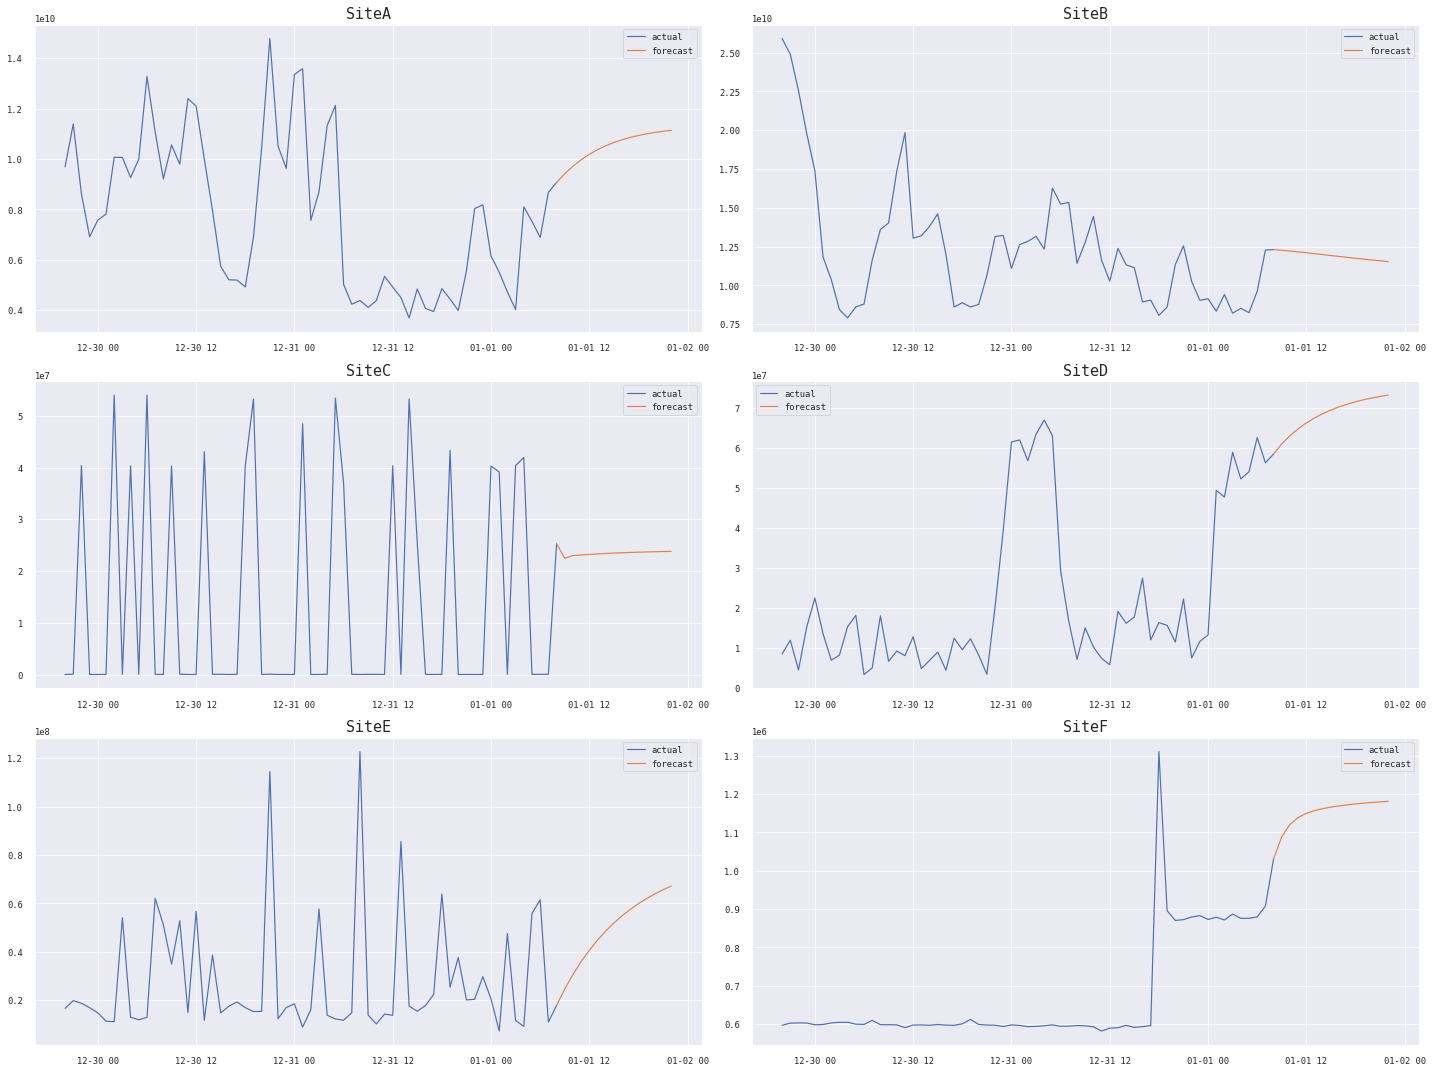

In [150]:
c = 1
fig = plt.figure(figsize=(20,15))
for col in df.columns:
    plt.subplot(3, 2, c)
    plt.title(f'{col}', size=15)
    plt.tight_layout()
    # plt.plot(df[8700:][col])
    plt.plot(df_full[8700:len(df)+1][col], label='actual')
    plt.plot(df_full[len(df):][col], label='forecast')
    plt.legend()
    c += 1
plt.show() 